In [1]:
# ========== 1. Setup ==========
import os, glob, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_recall_fscore_support
import torch
import torch.nn as nn
import joblib

print(f"PyTorch version: {torch.__version__}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version: 2.7.0+cpu
Using device: cpu


In [11]:
# Diagnostic: quick check of data files (lightweight)
path = "../data/1st_test/"
files = sorted(glob.glob(os.path.join(path, "*")))
print(f"Found {len(files)} files in {path}")
print("First 5 files:")
for f in files[:5]:
    print(f)

Found 2156 files in ../data/1st_test/
First 5 files:
../data/1st_test\2003.10.22.12.06.24
../data/1st_test\2003.10.22.12.09.13
../data/1st_test\2003.10.22.12.14.13
../data/1st_test\2003.10.22.12.19.13
../data/1st_test\2003.10.22.12.24.13


In [12]:
# ---------- 2. Load and preprocess ----------
# Use path relative to the notebooks folder so the notebook can be run from the project root
path = "../data/1st_test/"   # update this to your dataset path (relative to notebooks/)
# Get all files in the directory (data files in this dataset don't use a .txt extension)
files = sorted(glob.glob(os.path.join(path, "*")))

stats = []
for f in files:
    try:
        # Files are tab-separated with multiple columns (sensor channels)
        data = np.loadtxt(f, delimiter='\t')
        # Compute per-file summary statistics (or change to per-row if desired)
        mean_ = np.mean(data)
        std_ = np.std(data)
        rms_ = np.sqrt(np.mean(data**2))
        kurt_ = pd.Series(data.ravel()).kurt()
        skew_ = pd.Series(data.ravel()).skew()
        ptp_  = np.ptp(data)
        stats.append([mean_, std_, rms_, kurt_, skew_, ptp_])
    except Exception as e:
        print(f"Error loading file {f}: {str(e)}")

df = pd.DataFrame(stats, columns=['mean','std','rms','kurt','skew','ptp'])
df['time'] = np.arange(len(df))
print(f"Successfully loaded {len(stats)} file summaries (rows)")
df.head()

Successfully loaded 2156 file summaries (rows)


,mean,std,rms,kurt,skew,ptp,time
0,-0.092867,0.080090,0.122632,1.128642,0.001843,1.485,0
1,-0.092818,0.079282,0.122069,1.077398,-0.035649,1.235,1
2,-0.094864,0.079446,0.123737,0.992040,-0.000240,1.172,2
3,-0.094414,0.080206,0.123883,0.952116,-0.020383,1.219,3
4,-0.094372,0.079854,0.123623,0.898268,-0.020409,1.196,4


In [ ]:
# ---------- 3. Feature engineering ----------
# Create rolling statistics (operates on the 'rms' column)
for w in [3,5,10]:
    df[f'roll_mean_{w}'] = df['rms'].rolling(window=w, min_periods=1).mean()
    df[f'roll_std_{w}']  = df['rms'].rolling(window=w, min_periods=1).std().fillna(0)

# Handle any remaining missing values
df = df.bfill().ffill()  # Using newer pandas methods instead of deprecated fillna(method=...)

# Prepare features for scaling
X = df.drop(columns=['time'])

# Guard: ensure we have samples before scaling
if X.shape[0] == 0:
    raise ValueError("No samples found in feature matrix X. Check that data files were loaded correctly and that 'files' is not empty.")

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "../models/scaler.joblib")

['../models/scaler.joblib']

In [14]:
# ---------- 4. Isolation Forest ----------
if_model = IsolationForest(n_estimators=200, contamination=0.05, random_state=42)
if_model.fit(X_scaled)
scores = -if_model.decision_function(X_scaled)
threshold = np.percentile(scores, 95)
pred = (scores > threshold).astype(int)
df['IF_anomaly'] = pred



In [17]:
len(pred)

2156

In [18]:
df

,mean,std,rms,kurt,skew,ptp,time,roll_mean_3,roll_std_3,roll_mean_5,roll_std_5,roll_mean_10,roll_std_10,IF_anomaly
0,-0.092867,0.080090,0.122632,1.128642,0.001843,1.485,0,0.122632,0.000000,0.122632,0.000000,0.122632,0.000000,1
1,-0.092818,0.079282,0.122069,1.077398,-0.035649,1.235,1,0.122350,0.000399,0.122350,0.000399,0.122350,0.000399,1
2,-0.094864,0.079446,0.123737,0.992040,-0.000240,1.172,2,0.122813,0.000849,0.122813,0.000849,0.122813,0.000849,0
3,-0.094414,0.080206,0.123883,0.952116,-0.020383,1.219,3,0.123230,0.001008,0.123080,0.000876,0.123080,0.000876,0
4,-0.094372,0.079854,0.123623,0.898268,-0.020409,1.196,4,0.123748,0.000130,0.123189,0.000796,0.123189,0.000796,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2151,-0.116010,0.174643,0.209663,5.149117,0.022453,5.825,2151,0.209089,0.000719,0.209298,0.000803,0.208020,0.002302,1
2152,-0.114880,0.266675,0.290367,26.316668,-0.053399,9.998,2152,0.236451,0.046694,0.225605,0.036211,0.216460,0.026060,1
2153,-0.115335,0.285014,0.307466,26.726871,0.120860,9.902,2153,0.269165,0.052235,0.245020,0.049573,0.226478,0.038451,1
2154,-0.117053,0.260950,0.286000,21.503704,-0.137676,9.191,2154,0.294611,0.011344,0.260563,0.047307,0.234826,0.041605,1


In [19]:
# ---------- 5. Deep Learning: LSTM Autoencoder ----------
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Encoder
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Decoder
        self.decoder = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, input_size)
    
    def forward(self, x):
        # Encode
        _, (hidden, cell) = self.encoder(x)
        
        # Create decoder input
        decoder_input = hidden[-1].unsqueeze(1).repeat(1, x.size(1), 1)
        
        # Decode
        out, _ = self.decoder(decoder_input)
        out = self.output_layer(out)
        return out

# Prepare sequences
seq_len = 30
def create_sequences(X, seq_len=30):
    seqs = []
    for i in range(len(X)-seq_len):
        seqs.append(X[i:i+seq_len])
    return np.array(seqs)

seqs = create_sequences(X_scaled, seq_len)
print(f"Sequence shape: {seqs.shape}")

# Convert to PyTorch tensors
seqs_tensor = torch.FloatTensor(seqs).to(device)

# Create and train model
model = LSTMAutoencoder(input_size=X_scaled.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

n_epochs = 40
batch_size = 64
train_size = int(0.8 * len(seqs_tensor))
train_data = seqs_tensor[:train_size]
val_data = seqs_tensor[train_size:]

best_val_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in range(n_epochs):
    # Training
    model.train()
    total_loss = 0
    for i in range(0, len(train_data), batch_size):
        batch = train_data[i:i+batch_size]
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(val_data)
        val_loss = criterion(val_output, val_data).item()
    
    print(f'Epoch {epoch+1}, Train Loss: {total_loss/len(train_data):.6f}, Val Loss: {val_loss:.6f}')
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "../models/lstm_autoencoder.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Load best model and compute reconstruction error
model.load_state_dict(torch.load("../models/lstm_autoencoder.pth"))
model.eval()

with torch.no_grad():
    recons = model(seqs_tensor).cpu().numpy()
    mse = np.mean(np.mean((recons - seqs)**2, axis=2), axis=1)
    thresh = np.percentile(mse, 95)
    anom_seq = (mse > thresh).astype(int)

Sequence shape: (2126, 30, 12)
Epoch 1, Train Loss: 0.006039, Val Loss: 1.970108
Epoch 2, Train Loss: 0.005266, Val Loss: 1.916218
Epoch 3, Train Loss: 0.004721, Val Loss: 1.773638
Epoch 4, Train Loss: 0.003736, Val Loss: 1.609092
Epoch 5, Train Loss: 0.002349, Val Loss: 1.442398
Epoch 6, Train Loss: 0.001748, Val Loss: 1.294993
Epoch 7, Train Loss: 0.001733, Val Loss: 1.206284
Epoch 8, Train Loss: 0.001653, Val Loss: 1.175336
Epoch 9, Train Loss: 0.001643, Val Loss: 1.141318
Epoch 10, Train Loss: 0.001720, Val Loss: 1.117514
Epoch 11, Train Loss: 0.001656, Val Loss: 1.296134
Epoch 12, Train Loss: 0.001732, Val Loss: 1.161967
Epoch 13, Train Loss: 0.001887, Val Loss: 1.208590
Epoch 14, Train Loss: 0.001652, Val Loss: 1.169259
Epoch 15, Train Loss: 0.001517, Val Loss: 1.171305
Early stopping triggered


In [20]:
# ---------- 6. Map sequence anomalies back ----------
df['AE_anomaly'] = 0
for i, val in enumerate(anom_seq):
    if val == 1:
        df.loc[i:i+seq_len, 'AE_anomaly'] = 1



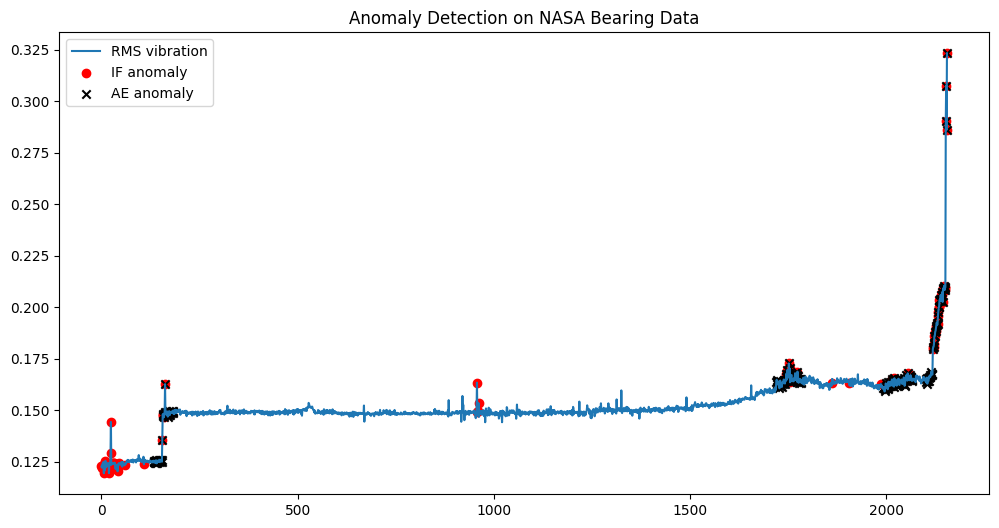

In [21]:
# ---------- 7. Visualization ----------
plt.figure(figsize=(12,6))
plt.plot(df['time'], df['rms'], label='RMS vibration')
plt.scatter(df['time'][df['IF_anomaly']==1], df['rms'][df['IF_anomaly']==1],
            color='r', marker='o', label='IF anomaly')
plt.scatter(df['time'][df['AE_anomaly']==1], df['rms'][df['AE_anomaly']==1],
            color='k', marker='x', label='AE anomaly')
plt.title('Anomaly Detection on NASA Bearing Data')
plt.legend()
plt.savefig("../outputs/anomaly_visualization.png")
plt.show()
